<a href="https://colab.research.google.com/github/ravindrabharathi/Project1/blob/master/Session7/Assignment7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Classification of CIFAR 10 dataset using ENAS discovered network 

In this exercise we will design a network for CIFAR 10 dataset using the network presented in this paper ['Efficient Neural Architecture Search via Parameter Sharing'](https://arxiv.org/pdf/1802.03268.pdf)

###Import necessary Modules 

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


###create train and test data using cifar10 dataset in Keras 

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 13s 0us/step


###Plot some of the images in the dataset along with class label

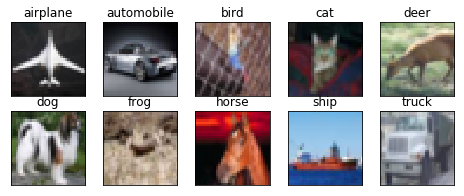

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

###Scale the input features to be within 0 and 1 
###convert the train and test labels to 10 class category format 

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

##Define the Model 

### The model will be designed as per the following ENAS's discovered network 
![Enas discovered Network](https://raw.githubusercontent.com/ravindrabharathi/eip3/master/images/enas-network.png)

We will also consider the following points mentioned in the paper while designing the network 

>>### *B. Details on CIFAR-10 Experiments*
*We find the following tricks crucial for achieving good performance with ENAS. Standard NAS (Zoph & Le, 2017;*
*Zoph et al., 2018) rely on these and other tricks as well.*
*Structure of Convolutional Layers. Each convolution in our model is applied in the order of relu-convbatchnorm (Ioffe & Szegedy, 2015; He et al., 2016b). Additionally, in our micro search space, each depthwise separable convolution is applied twice (Zoph et al., 2018). *

>>#### *Stabilizing Stochastic Skip Connections.*
*If a layer receives skip connections from multiple layers before it, then
these layers’ outputs are concatenated in their depth dimension, and then a convolution of filter size 1 × 1 (followed
by a batch normalization layer and a ReLU layer)*

>>#### *Global Average Pooling*
*After the final convolutional
layer, we average all the activations of each channel and
then pass them to the Softmax layer.*

>>#### *Number of filters (mentioned in section 3.2. Image Classification on CIFAR-10 of the paper under Results (page 5))*
*If we keep
the architecture, but increase the number of filters in the
network’s highest layer to 512, then the test error decreases
to 3.87%, which is not far away from NAS’s best model,
whose test error is 3.65% .* 

####For our network , we will follow this rule for numer of kernels   

Start with 32 filters , followed by 64 , then 128 filters and then finally 256 filters . For the last block alone we will use 64 ->128 ->256 ->512 filters.

As noted above after we concatenate ,we reduce the number of filters to follow the above rule for kernel numbers before sending the activation maps to the next layer 



>>>>>> ### Details of skip connections and number of kernels 



| Layer Name | Layer type |  number of kernels   | layers feeding into this layer | 
| :--- | :---: | :---: | :---: |
| layer1  |  Sep Conv 5x5 |  32 | input_layer |
| layer2  | Conv 5x5  | 64  | layer1 |
| layer3     | Sep Conv 5x5 | 128 | layer2 | 
| layer4  | Conv 5x5  | 256  | layer1, layer3 |
| MP1  | MaxPool 2x2 | -  | layer1,layer4 |
| layer5  | Sep Conv 3x3  | 32  | MP1 |
| layer6  | Conv 5x5  | 64  | layer1,layer4,layer5 |
| layer7  | Sep Conv 3x3  | 128  | layer3,layer4,layer5,layer6 |
| layer8  | Sep Conv 5x5  | 256  | layer1,layer3,layer4,layer5,layer6,layer7 |
| MP2  | MaxPool 2x2  | -  | layer1,layer4,layer5,layer7,layer8 |
| layer9  | Conv 5x5  | 64  | layer6,MP2 |
| layer10  | Sep Conv 5x5  | 128  | layer2,layer4,layer7,layer9 |
| layer11  | Conv 3x3  | 256  | layer2,layer3,layer5,layer9,layer10 |
| layer12  | Sep Conv 5x5  | 512  | layer1,layer3,layer4,layer5,layer7,layer10,layer11 |
| output  |Softmax  | -  | layer4,,layer7,layer10,layer12 |








In [0]:
#layers are connected as follows
#layer no. | incoming


#4         - 1,3 
#mp1       - 1,4 
#6         - 1,4,5  
#7         - 3,4,5,6 
#8         - 6, 3, 5, 4,1,7
#mp2       - 7, 5,1,4 ,8
#9         -6,mp2 
#10        - 2,7,4,9
#11        - 2,3, 5,10,9
#12        - 10,7,3,4,5,1,11
#smax      - 4,7,10,12


# space to depth functions to transform shape in order to concatenate 
# since spatial dimensions need to match while concatenating

def space_to_depth_x2(x,block_size=2):
    import tensorflow as tf
    return tf.space_to_depth(x, block_size)
  
def space_to_depth_x4(x,block_size=4):
    import tensorflow as tf
    return tf.space_to_depth(x, block_size) 
  


In [0]:
from keras.layers.convolutional import Conv2D
from keras.layers import Input, SeparableConv2D,BatchNormalization, Lambda ,AveragePooling2D,GlobalAveragePooling2D
from keras.layers.advanced_activations import ReLU
from keras.models import Model,  load_model
from keras.layers.merge import concatenate

In [10]:
#BUILD THE MODEL

#input layer size 32 x 32 and 3 color channels 
input_layer = Input(shape=(32, 32, 3))


#depthwise separable conv2d , size 5
layer1 = SeparableConv2D(32, 5,padding='same', name='layer1' ) (input_layer) 

layer1 = BatchNormalization(name='BN1')(layer1)
layer1 = ReLU(name='R1')(layer1)

#conv2d size 5
layer2=Conv2D(64,5, padding='same', name='layer2') (layer1)

layer2=BatchNormalization(name='BN2')(layer2)
layer2=ReLU(name='R2')(layer2)


#conv2d size 5
layer3=Conv2D(128,5, padding='same',name='layer3') (layer2)

layer3=BatchNormalization(name='BN3')(layer3)
layer3=ReLU(name='R3')(layer3)

#concatenate layers wherever a skip connection has been shown
#1+3 ->4 
sc1=concatenate([layer1,layer3],name='sc1')

#reduce the channel numbers after concatenation to follow the 32->64->128->256 rule before sending to next layer 
reducer1=Conv2D(128, 1,name='red1' )(sc1)
reducer1=BatchNormalization(name='RBN1')(reducer1)
reducer1 = ReLU(name='RR1')(reducer1)

#depthwise separable conv2d , size 5
layer4 = SeparableConv2D(256, 5, padding='same',name='layer4' ) (reducer1) 

layer4 = BatchNormalization(name='BN4')(layer4)
layer4 = ReLU(name='R4')(layer4)

#1,4 -> mp1
sc2=concatenate([layer1,layer4],name='sc2')

reducer2=Conv2D(32, 1,name='red2' )(sc2)
reducer2=BatchNormalization(name='RBN2')(reducer2)
reducer2 = ReLU(name='RR2')(reducer2)

MP1=MaxPooling2D(pool_size=(2, 2),name='MP1')(reducer2)                          


layer5 = SeparableConv2D(32, 3, padding='same',name='layer5' ) (MP1) 

layer5 = BatchNormalization(name='BN5')(layer5)
layer5 = ReLU(name='R5')(layer5)

#1,4,5 -> 6
sc3=concatenate([Lambda(space_to_depth_x2)(layer1),Lambda(space_to_depth_x2)(layer4),layer5],name='sc3')

reducer3=Conv2D(32, 1,name='red3' )(sc3)
reducer3=BatchNormalization(name='RBN3')(reducer3)
reducer3 = ReLU(name='RR3')(reducer3)

layer6=Conv2D(64,5, padding='same', name='layer6') (reducer3)

layer6=BatchNormalization(name='BN6')(layer6)
layer6=ReLU(name='R6')(layer6)

#3,4,5,6 -> 7
sc4 = concatenate([Lambda(space_to_depth_x2)(layer3),Lambda(space_to_depth_x2)(layer4),layer5,layer6],name='sc4')

reducer4=Conv2D(64, 1,name='red4' )(sc4)
reducer4=BatchNormalization(name='RBN4')(reducer4)
reducer4 = ReLU(name='RR4')(reducer4)

layer7=SeparableConv2D(128,3,padding='same', name='layer7') (reducer4)

layer7=BatchNormalization(name='BN7')(layer7)
layer7=ReLU(name='R7')(layer7)

#6, 3, 5, 4,1,7 -> 8
sc5 = concatenate([Lambda(space_to_depth_x2)(layer1),Lambda(space_to_depth_x2)(layer3),Lambda(space_to_depth_x2)(layer4),
                   layer5,layer6,layer7],name='sc5')

reducer5=Conv2D(128, 1,name='red5' )(sc5)
reducer5=BatchNormalization(name='RBN5')(reducer5)
reducer5 = ReLU(name='RR5')(reducer5)

layer8 = SeparableConv2D(256, 5, padding='same',name='layer8' ) (reducer5) 

layer8 = BatchNormalization(name='BN8')(layer8)
layer8 = ReLU(name='R8')(layer8)

#7, 5,1,4 ,8 -> mp2
sc6=  concatenate([Lambda(space_to_depth_x2)(layer1),Lambda(space_to_depth_x2)(layer4),
                   layer5,layer7,layer8],name='sc6')

reducer6=Conv2D(64, 1,name='red6' )(sc6)
reducer6=BatchNormalization(name='RBN6')(reducer6)
reducer6 = ReLU(name='RR6')(reducer6)


MP2=MaxPooling2D(pool_size=(2, 2),name='MP2')(reducer6)  

#6,mp2 ->9
sc7= concatenate([Lambda(space_to_depth_x2)(layer6),MP2])

reducer7=Conv2D(64, 1,name='red7' )(sc7)
reducer7=BatchNormalization(name='RBN7')(reducer7)
reducer7 = ReLU(name='RR7')(reducer7)

layer9=Conv2D(64,5,  padding='same',name='layer9') (reducer7)

layer9=BatchNormalization(name='BN9')(layer9)
layer9=ReLU(name='R9')(layer9)

#2,7,4,9 -> 10
sc8 = concatenate([Lambda(space_to_depth_x4)(layer2),Lambda(space_to_depth_x4)(layer4),
                   Lambda(space_to_depth_x2)(layer7),
                   layer9],name='sc8')

reducer8=Conv2D(64, 1,name='red8' )(sc8)
reducer8=BatchNormalization(name='RBN8')(reducer8)
reducer8 = ReLU(name='RR8')(reducer8)

layer10 = SeparableConv2D(128, 5, padding='same',name='layer10' ) (reducer8) 

layer10 = BatchNormalization(name='BN10')(layer10)
layer10 = ReLU(name='R10')(layer10)

#2,3, 5,10,9 -> 11
sc9 = concatenate([Lambda(space_to_depth_x4)(layer2),Lambda(space_to_depth_x4)(layer3),
                   Lambda(space_to_depth_x2)(layer5),layer10,layer9],name='sc9')
 

reducer9=Conv2D(128, 1,name='red9' )(sc9)
reducer9=BatchNormalization(name='RBN9')(reducer9)
reducer9 = ReLU(name='RR9')(reducer9)  
  
layer11=Conv2D(256,3, padding='same',name='layer11') (reducer9)

layer11=BatchNormalization(name='BN11')(layer11)
layer11=ReLU(name='R11')(layer11)


#10,7,3,4,5,1,11 -> 12 
sc10 = concatenate([Lambda(space_to_depth_x4)(layer1),Lambda(space_to_depth_x4)(layer3),
                   Lambda(space_to_depth_x4)(layer4),Lambda(space_to_depth_x2)(layer5),
                   Lambda(space_to_depth_x2)(layer7), layer10,layer11],name='sc10')

reducer10=Conv2D(256, 1,name='red10' )(sc10)
reducer10=BatchNormalization(name='RBN10')(reducer10)
reducer10= ReLU(name='RR10')(reducer10)

layer12 = SeparableConv2D(512, 5, padding='same',name='layer12' ) (reducer10) 

layer12 = BatchNormalization(name='BN12')(layer12)
layer12 = ReLU(name='R12')(layer12)

#4,7,10,12 -> softmax
sc11= concatenate([Lambda(space_to_depth_x4)(layer4),
                   Lambda(space_to_depth_x2)(layer7), layer10,layer12],name='sc11')


#Pointwise convolution to squash incoming channels to 10 output channels 
layer13=(Conv2D(10,1, name='layer13'))(sc11)

layer13 = BatchNormalization(name='BN13')(layer13)
layer13 = ReLU(name='R13')(layer13)

# We are at a point where the activation channels have a spatial size of 8x8 . We do not want to use a 8x8 conv layer 

# Instead we will add Average Pooling with pool size same as the input in order to mimic Global Average Pooling 

layer14 = GlobalAveragePooling2D()(layer13) 

#Flatten the output 
#flat_layer=(Flatten(name='flat_layer'))(layer14)

#Softmax activation to output likelihood values for classes 

output=Activation('softmax')(layer14)

#Assign the Model input and output

model = Model(inputs=[input_layer], outputs=[output])



W0622 04:22:48.226043 140147713496960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0622 04:22:48.241873 140147713496960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0622 04:22:48.245374 140147713496960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0622 04:22:48.280554 140147713496960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0622 04:22:48.281399 1401477134

####plot the model as a png image and display it 



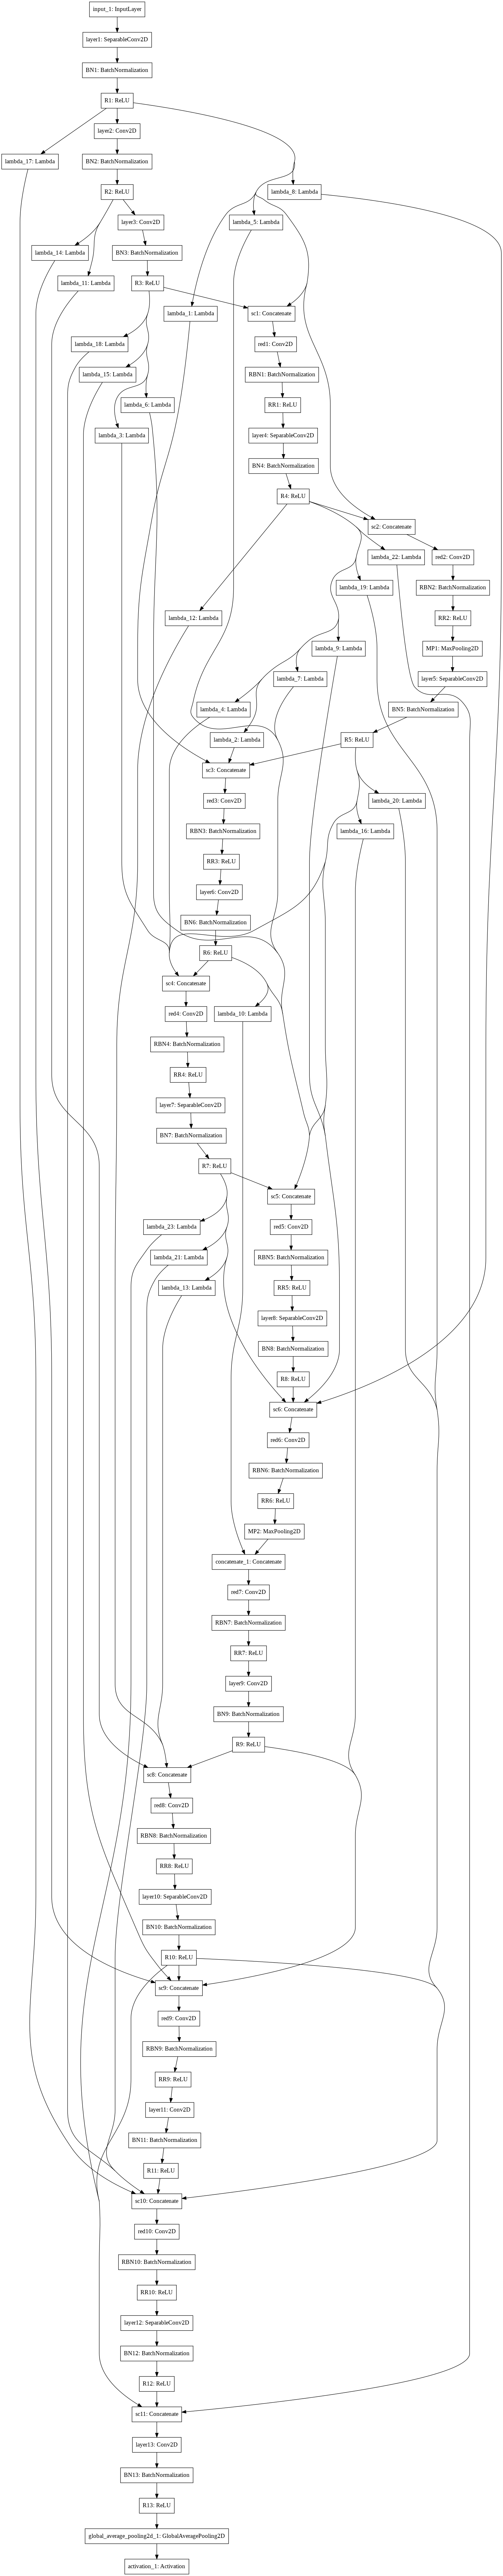

In [11]:
#plot the model as a png image and display it 

from keras.utils import plot_model
plot_model(model, to_file='model.png')

from IPython.display import Image, display
display(Image('model.png',width=1000,height=3000))

####print model summary

In [12]:
#Print model summary 
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
layer1 (SeparableConv2D)        (None, 32, 32, 32)   203         input_1[0][0]                    
__________________________________________________________________________________________________
BN1 (BatchNormalization)        (None, 32, 32, 32)   128         layer1[0][0]                     
__________________________________________________________________________________________________
R1 (ReLU)                       (None, 32, 32, 32)   0           BN1[0][0]                        
__________________________________________________________________________________________________
layer2 (Co

In [11]:
from google.colab import drive

drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
from keras.callbacks import ModelCheckpoint

chkpoint_model=ModelCheckpoint("/gdrive/My Drive/EVA/session7/model_enas_custom7_cifar10_best.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

###Learning Rate Scheduler : 
####We will add a custom learning rate scheduler that reduces the rate every 2nd epoch sugject to a min of 0.0001. We will also start with a slightly larger lr of 0.003 compared to default of 0.001 for Adam optimizer. 

####Reducing Learning rate only when training plateaus is a better option compared to what we are doing here 

In [10]:
# define a learning rate scheduler . We will use a simple scheduler that reduces the lr by 10% every 3 epochs subject to a minimum lr of 0.0001 
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  if (epoch%2==0 and epoch):
    new_lr = max(0.9*lr,0.00001) 
  else:
    new_lr=lr
  
  return round(new_lr, 10)

reduceLR=LearningRateScheduler(scheduler,verbose=1)
  
'''
from keras.callbacks import ReduceLROnPlateau
  
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=2, cooldown=1,min_lr=0.00001,verbose=1)  
                              
                              '''



"\nfrom keras.callbacks import ReduceLROnPlateau\n  \nreduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.9,\n                              patience=2, cooldown=1,min_lr=0.00001,verbose=1)  \n                              \n                              "

In [16]:
#comile model with Adam optimizer , start with a higher lr of 0.003 
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

W0622 04:22:52.515358 140147713496960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



###Image Normalization and Augmentation : 
In order to help the network generalize better , we will normalize the input image with mu-sigma normalization and also augment the training image samples by using image augmentation techniques. We will add some transforms in  random combinations like a zoom factor, shift of image  and flipping the image horizontally. To do this we will use an ImageDataGenerator 

#### Define Imagedatagenerator with various combinations of horizontal flip set to True ,zoom range , shift image along width  , shift image along height   . All these will be applied in random combinations 

We will then train model for a total of 100 epochs 



In [17]:
from keras.preprocessing.image import ImageDataGenerator



train_datagen = ImageDataGenerator( 
                             horizontal_flip=True,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 3, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))


W0622 04:22:54.178591 140147713496960 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/3

Epoch 00001: LearningRateScheduler setting learning rate to 0.0099999998.
391/391 [==============================] - 129s 330ms/step - loss: 1.3988 - acc: 0.5075 - val_loss: 2.3173 - val_acc: 0.4216

Epoch 00001: val_acc improved from -inf to 0.42160, saving model to /gdrive/My Drive/EVA/session7/model_enas_custom7_cifar10_best.h5
Epoch 2/3

Epoch 00002: LearningRateScheduler setting learning rate to 0.0099999998.
391/391 [==============================] - 115s 295ms/step - loss: 0.8463 - acc: 0.7073 - val_loss: 0.9486 - val_acc: 0.6742

Epoch 00002: val_acc improved from 0.42160 to 0.67420, saving model to /gdrive/My Drive/EVA/session7/model_enas_custom7_cifar10_best.h5
Epoch 3/3

Epoch 00003: LearningRateScheduler setting learning rate to 0.0089999998.
391/391 [==============================] - 115s 295ms/step - loss: 0.6401 - acc: 0.7801 - val_loss: 0.8561 - val_acc: 0.7189

Epoch 00003: val_acc improved from 0.67420 to 0.71890, saving model to /gdrive/My Drive/EVA/sessio

In [18]:
train_datagen = ImageDataGenerator(zoom_range=[0.8,0.8], 
                             horizontal_flip=True, width_shift_range=0.5, height_shift_range=0.5,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 20, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.0089999996.
391/391 [==============================] - 115s 295ms/step - loss: 1.2470 - acc: 0.5663 - val_loss: 1.9074 - val_acc: 0.4149

Epoch 00001: val_acc did not improve from 0.71890
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0089999996.
391/391 [==============================] - 115s 294ms/step - loss: 1.0806 - acc: 0.6233 - val_loss: 1.4350 - val_acc: 0.5759

Epoch 00002: val_acc did not improve from 0.71890
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0080999997.
391/391 [==============================] - 115s 294ms/step - loss: 1.0033 - acc: 0.6507 - val_loss: 0.9889 - val_acc: 0.6818

Epoch 00003: val_acc did not improve from 0.71890
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0080999993.
391/391 [==============================] - 115s 295ms/step - loss: 0.9523 - acc: 0.6698 - val_loss: 1.5311 - val_acc: 0.5689

Ep

In [19]:
train_datagen = ImageDataGenerator(
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 5, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.0034867842.
391/391 [==============================] - 115s 295ms/step - loss: 0.2494 - acc: 0.9150 - val_loss: 0.3141 - val_acc: 0.8905

Epoch 00001: val_acc improved from 0.75210 to 0.89050, saving model to /gdrive/My Drive/EVA/session7/model_enas_custom7_cifar10_best.h5
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.0034867842.
391/391 [==============================] - 115s 295ms/step - loss: 0.1603 - acc: 0.9484 - val_loss: 0.3200 - val_acc: 0.8897

Epoch 00002: val_acc did not improve from 0.89050
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0031381058.
391/391 [==============================] - 115s 294ms/step - loss: 0.0974 - acc: 0.9704 - val_loss: 0.3130 - val_acc: 0.8977

Epoch 00003: val_acc improved from 0.89050 to 0.89770, saving model to /gdrive/My Drive/EVA/session7/model_enas_custom7_cifar10_best.h5
Epoch 4/5

Epoch 00004: LearningRateScheduler

In [20]:




train_datagen = ImageDataGenerator(zoom_range=[0.8,1], 
                             horizontal_flip=True, width_shift_range=0.35, height_shift_range=0.35,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 7, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))


Epoch 1/7

Epoch 00001: LearningRateScheduler setting learning rate to 0.0028242953.
391/391 [==============================] - 115s 295ms/step - loss: 0.4214 - acc: 0.8556 - val_loss: 0.5041 - val_acc: 0.8394

Epoch 00001: val_acc did not improve from 0.89770
Epoch 2/7

Epoch 00002: LearningRateScheduler setting learning rate to 0.0028242953.
391/391 [==============================] - 115s 294ms/step - loss: 0.3631 - acc: 0.8736 - val_loss: 0.4319 - val_acc: 0.8603

Epoch 00002: val_acc did not improve from 0.89770
Epoch 3/7

Epoch 00003: LearningRateScheduler setting learning rate to 0.0025418658.
391/391 [==============================] - 115s 295ms/step - loss: 0.3358 - acc: 0.8829 - val_loss: 0.4947 - val_acc: 0.8398

Epoch 00003: val_acc did not improve from 0.89770
Epoch 4/7

Epoch 00004: LearningRateScheduler setting learning rate to 0.0025418657.
391/391 [==============================] - 115s 295ms/step - loss: 0.3327 - acc: 0.8844 - val_loss: 0.4645 - val_acc: 0.8535

Epoch 

In [21]:
train_datagen = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.25, height_shift_range=0.25,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 10, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.0020589111.
391/391 [==============================] - 115s 295ms/step - loss: 0.1990 - acc: 0.9308 - val_loss: 0.3338 - val_acc: 0.8925

Epoch 00001: val_acc did not improve from 0.89770
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0020589111.
391/391 [==============================] - 115s 294ms/step - loss: 0.1845 - acc: 0.9368 - val_loss: 0.3462 - val_acc: 0.8872

Epoch 00002: val_acc did not improve from 0.89770
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.00185302.
391/391 [==============================] - 115s 295ms/step - loss: 0.1770 - acc: 0.9386 - val_loss: 0.3199 - val_acc: 0.8983

Epoch 00003: val_acc improved from 0.89770 to 0.89830, saving model to /gdrive/My Drive/EVA/session7/model_enas_custom7_cifar10_best.h5
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.00185302.
391/391 [==============================] - 115

In [22]:




train_datagen = ImageDataGenerator(
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 5, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))


Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.0013508516.
391/391 [==============================] - 115s 295ms/step - loss: 0.0269 - acc: 0.9951 - val_loss: 0.2619 - val_acc: 0.9174

Epoch 00001: val_acc improved from 0.90330 to 0.91740, saving model to /gdrive/My Drive/EVA/session7/model_enas_custom7_cifar10_best.h5
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.0013508516.
391/391 [==============================] - 115s 295ms/step - loss: 0.0135 - acc: 0.9988 - val_loss: 0.2583 - val_acc: 0.9195

Epoch 00002: val_acc improved from 0.91740 to 0.91950, saving model to /gdrive/My Drive/EVA/session7/model_enas_custom7_cifar10_best.h5
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0012157665.
391/391 [==============================] - 115s 295ms/step - loss: 0.0096 - acc: 0.9996 - val_loss: 0.2611 - val_acc: 0.9200

Epoch 00003: val_acc improved from 0.91950 to 0.92000, saving model to /gdrive/My Drive/EVA/ses

In [23]:




train_datagen = ImageDataGenerator(zoom_range=[0.8,1.0], 
                             horizontal_flip=True, width_shift_range=0.3, height_shift_range=0.3,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 10, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))


Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010941899.
391/391 [==============================] - 115s 295ms/step - loss: 0.2350 - acc: 0.9186 - val_loss: 0.4023 - val_acc: 0.8845

Epoch 00001: val_acc did not improve from 0.92000
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010941899.
391/391 [==============================] - 115s 295ms/step - loss: 0.1808 - acc: 0.9381 - val_loss: 0.4166 - val_acc: 0.8787

Epoch 00002: val_acc did not improve from 0.92000
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009847709.
391/391 [==============================] - 115s 295ms/step - loss: 0.1690 - acc: 0.9414 - val_loss: 0.3604 - val_acc: 0.8903

Epoch 00003: val_acc did not improve from 0.92000
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009847709.
391/391 [==============================] - 115s 294ms/step - loss: 0.1701 - acc: 0.9418 - val_loss: 0.3606 - val_acc: 0.8905

Ep

In [24]:
train_datagen = ImageDataGenerator( 
                             horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1,rotation_range=5,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 5, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.000717898.
391/391 [==============================] - 115s 295ms/step - loss: 0.0764 - acc: 0.9749 - val_loss: 0.2887 - val_acc: 0.9129

Epoch 00001: val_acc did not improve from 0.92000
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.000717898.
391/391 [==============================] - 115s 295ms/step - loss: 0.0664 - acc: 0.9795 - val_loss: 0.2947 - val_acc: 0.9115

Epoch 00002: val_acc did not improve from 0.92000
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006461082.
391/391 [==============================] - 115s 295ms/step - loss: 0.0628 - acc: 0.9798 - val_loss: 0.2906 - val_acc: 0.9132

Epoch 00003: val_acc did not improve from 0.92000
Epoch 4/5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0006461082.
391/391 [==============================] - 115s 295ms/step - loss: 0.0603 - acc: 0.9808 - val_loss: 0.2961 - val_acc: 0.9117

Epoch 00

In [25]:
train_datagen = ImageDataGenerator( 
                             horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 5, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.0005814974.
391/391 [==============================] - 115s 295ms/step - loss: 0.0697 - acc: 0.9777 - val_loss: 0.2982 - val_acc: 0.9132

Epoch 00001: val_acc did not improve from 0.92000
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.0005814974.
391/391 [==============================] - 115s 295ms/step - loss: 0.0585 - acc: 0.9822 - val_loss: 0.3103 - val_acc: 0.9087

Epoch 00002: val_acc did not improve from 0.92000
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0005233476.
391/391 [==============================] - 115s 295ms/step - loss: 0.0567 - acc: 0.9828 - val_loss: 0.3039 - val_acc: 0.9129

Epoch 00003: val_acc did not improve from 0.92000
Epoch 4/5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0005233476.
391/391 [==============================] - 115s 295ms/step - loss: 0.0537 - acc: 0.9837 - val_loss: 0.3093 - val_acc: 0.9113

Epoch 

In [26]:




train_datagen = ImageDataGenerator(zoom_range=[0.8,0.8], 
                             horizontal_flip=True, width_shift_range=0.4, height_shift_range=0.4,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 5, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))


Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.0004710128.
391/391 [==============================] - 115s 295ms/step - loss: 0.3488 - acc: 0.8818 - val_loss: 0.5028 - val_acc: 0.8614

Epoch 00001: val_acc did not improve from 0.92000
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.0004710128.
391/391 [==============================] - 115s 294ms/step - loss: 0.3057 - acc: 0.8923 - val_loss: 0.5383 - val_acc: 0.8518

Epoch 00002: val_acc did not improve from 0.92000
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0004239115.
391/391 [==============================] - 115s 295ms/step - loss: 0.2944 - acc: 0.8975 - val_loss: 0.4723 - val_acc: 0.8644

Epoch 00003: val_acc did not improve from 0.92000
Epoch 4/5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0004239115.
391/391 [==============================] - 115s 295ms/step - loss: 0.2941 - acc: 0.8979 - val_loss: 0.5089 - val_acc: 0.8572

Epoch 

In [27]:
train_datagen = ImageDataGenerator(zoom_range=[0.9,1.0], 
                             horizontal_flip=True, width_shift_range=0.3, height_shift_range=0.3,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 5, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.0003815203.
391/391 [==============================] - 115s 294ms/step - loss: 0.1248 - acc: 0.9580 - val_loss: 0.3367 - val_acc: 0.9008

Epoch 00001: val_acc did not improve from 0.92000
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.0003815203.
391/391 [==============================] - 115s 294ms/step - loss: 0.0871 - acc: 0.9730 - val_loss: 0.3458 - val_acc: 0.8993

Epoch 00002: val_acc did not improve from 0.92000
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0003433683.
391/391 [==============================] - 115s 295ms/step - loss: 0.0838 - acc: 0.9746 - val_loss: 0.3331 - val_acc: 0.9009

Epoch 00003: val_acc did not improve from 0.92000
Epoch 4/5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003433683.
391/391 [==============================] - 115s 295ms/step - loss: 0.0870 - acc: 0.9722 - val_loss: 0.3328 - val_acc: 0.9039

Epoch 

In [28]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 3, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))

Epoch 1/3

Epoch 00001: LearningRateScheduler setting learning rate to 0.0003090315.
391/391 [==============================] - 115s 295ms/step - loss: 0.0296 - acc: 0.9924 - val_loss: 0.2499 - val_acc: 0.9222

Epoch 00001: val_acc improved from 0.92000 to 0.92220, saving model to /gdrive/My Drive/EVA/session7/model_enas_custom7_cifar10_best.h5
Epoch 2/3

Epoch 00002: LearningRateScheduler setting learning rate to 0.0003090315.
391/391 [==============================] - 115s 295ms/step - loss: 0.0197 - acc: 0.9959 - val_loss: 0.2460 - val_acc: 0.9235

Epoch 00002: val_acc improved from 0.92220 to 0.92350, saving model to /gdrive/My Drive/EVA/session7/model_enas_custom7_cifar10_best.h5
Epoch 3/3

Epoch 00003: LearningRateScheduler setting learning rate to 0.0002781283.
391/391 [==============================] - 115s 295ms/step - loss: 0.0168 - acc: 0.9967 - val_loss: 0.2470 - val_acc: 0.9230

Epoch 00003: val_acc did not improve from 0.92350
Model took 349.62 seconds to train



In [29]:




train_datagen = ImageDataGenerator(zoom_range=[0.8,1.0], 
                             horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 7, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))


Epoch 1/7

Epoch 00001: LearningRateScheduler setting learning rate to 0.0002781283.
391/391 [==============================] - 115s 295ms/step - loss: 0.0582 - acc: 0.9811 - val_loss: 0.3102 - val_acc: 0.9097

Epoch 00001: val_acc did not improve from 0.92350
Epoch 2/7

Epoch 00002: LearningRateScheduler setting learning rate to 0.0002781283.
391/391 [==============================] - 115s 295ms/step - loss: 0.0464 - acc: 0.9861 - val_loss: 0.3337 - val_acc: 0.9018

Epoch 00002: val_acc did not improve from 0.92350
Epoch 3/7

Epoch 00003: LearningRateScheduler setting learning rate to 0.0002503155.
391/391 [==============================] - 115s 295ms/step - loss: 0.0421 - acc: 0.9867 - val_loss: 0.3371 - val_acc: 0.9028

Epoch 00003: val_acc did not improve from 0.92350
Epoch 4/7

Epoch 00004: LearningRateScheduler setting learning rate to 0.0002503155.
391/391 [==============================] - 115s 295ms/step - loss: 0.0448 - acc: 0.9866 - val_loss: 0.3318 - val_acc: 0.9062

Epoch 

In [30]:
train_datagen = ImageDataGenerator(
                             horizontal_flip=True, 
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 5, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.0002027555.
391/391 [==============================] - 115s 295ms/step - loss: 0.0149 - acc: 0.9973 - val_loss: 0.2570 - val_acc: 0.9231

Epoch 00001: val_acc did not improve from 0.92350
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.0002027555.
391/391 [==============================] - 115s 295ms/step - loss: 0.0115 - acc: 0.9986 - val_loss: 0.2551 - val_acc: 0.9247

Epoch 00002: val_acc improved from 0.92350 to 0.92470, saving model to /gdrive/My Drive/EVA/session7/model_enas_custom7_cifar10_best.h5
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.00018248.
391/391 [==============================] - 115s 295ms/step - loss: 0.0103 - acc: 0.9990 - val_loss: 0.2549 - val_acc: 0.9239

Epoch 00003: val_acc did not improve from 0.92470
Epoch 4/5

Epoch 00004: LearningRateScheduler setting learning rate to 0.00018248.
391/391 [==============================] - 115s 29

In [31]:
train_datagen = ImageDataGenerator(
                             horizontal_flip=True,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 5, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.000164232.
391/391 [==============================] - 115s 295ms/step - loss: 0.0104 - acc: 0.9984 - val_loss: 0.2571 - val_acc: 0.9234

Epoch 00001: val_acc did not improve from 0.92480
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.000164232.
391/391 [==============================] - 115s 295ms/step - loss: 0.0068 - acc: 0.9998 - val_loss: 0.2574 - val_acc: 0.9236

Epoch 00002: val_acc did not improve from 0.92480
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001478088.
391/391 [==============================] - 115s 295ms/step - loss: 0.0063 - acc: 0.9999 - val_loss: 0.2587 - val_acc: 0.9242

Epoch 00003: val_acc did not improve from 0.92480
Epoch 4/5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001478088.
391/391 [==============================] - 115s 295ms/step - loss: 0.0063 - acc: 0.9998 - val_loss: 0.2599 - val_acc: 0.9232

Epoch 00

### We trained the model for 100 epochs and it reached a max validation accuracy of 92.48 


##Model With Lesser Parameters 

Let us change the kernel numbers in the model to reduce the number of parameters and see if there is any performance hit 

We will change the model such that all but the last block starts with 8 kernels and goes upto 128 kernels (8->16->32->128). Only the last block will be 16->32->64->128 . We will not use Droputs in this network. The rest of the elements in the network remain the same .

>>>>>> ### Details of skip connections and number of kernels 



| Layer Name | Layer type |  number of kernels   | layers feeding into this layer | 
| :--- | :---: | :---: | :---: |
| layer1  |  Sep Conv 5x5 |  8 | input_layer |
| layer2  | Conv 5x5  | 16  | layer1 |
| layer3     | Sep Conv 5x5 | 32 | layer2 | 
| layer4  | Conv 5x5  | 64  | layer1, layer3 |
| MP1  | MaxPool 2x2 | -  | layer1,layer4 |
| layer5  | Sep Conv 3x3  | 8  | MP1 |
| layer6  | Conv 5x5  | 16  | layer1,layer4,layer5 |
| layer7  | Sep Conv 3x3  | 32  | layer3,layer4,layer5,layer6 |
| layer8  | Sep Conv 5x5  | 64  | layer1,layer3,layer4,layer5,layer6,layer7 |
| MP2  | MaxPool 2x2  | -  | layer1,layer4,layer5,layer7,layer8 |
| layer9  | Conv 5x5  | 16  | layer6,MP2 |
| layer10  | Sep Conv 5x5  | 32  | layer2,layer4,layer7,layer9 |
| layer11  | Conv 3x3  | 64  | layer2,layer3,layer5,layer9,layer10 |
| layer12  | Sep Conv 5x5  | 128  | layer1,layer3,layer4,layer5,layer7,layer10,layer11 |
| output  |Softmax  | -  | layer4,,layer7,layer10,layer12 |



In [0]:
#BUILD THE MODEL

#input layer size 32 x 32 and 3 color channels 
input_layer = Input(shape=(32, 32, 3))


#depthwise separable conv2d , size 5
layer1 = SeparableConv2D(8, 5,padding='same', name='layer1' ) (input_layer) 

layer1 = BatchNormalization(name='BN1')(layer1)
layer1 = ReLU(name='R1')(layer1)

#conv2d size 5
layer2=Conv2D(16,5, padding='same', name='layer2') (layer1)

layer2=BatchNormalization(name='BN2')(layer2)
layer2=ReLU(name='R2')(layer2)


#conv2d size 5
layer3=Conv2D(32,5, padding='same',name='layer3') (layer2)

layer3=BatchNormalization(name='BN3')(layer3)
layer3=ReLU(name='R3')(layer3)

#concatenate layers wherever a skip connection has been shown
#1+3 ->4 
sc1=concatenate([layer1,layer3],name='sc1')

#reduce the channel numbers after concatenation to follow the 32->64->128->256 rule before sending to next layer 
reducer1=Conv2D(32, 1,name='red1' )(sc1)
reducer1=BatchNormalization(name='RBN1')(reducer1)
reducer1 = ReLU(name='RR1')(reducer1)

#depthwise separable conv2d , size 5
layer4 = SeparableConv2D(64, 5, padding='same',name='layer4' ) (reducer1) 

layer4 = BatchNormalization(name='BN4')(layer4)
layer4 = ReLU(name='R4')(layer4)

#1,4 -> mp1
sc2=concatenate([layer1,layer4],name='sc2')

reducer2=Conv2D(8, 1,name='red2' )(sc2)
reducer2=BatchNormalization(name='RBN2')(reducer2)
reducer2 = ReLU(name='RR2')(reducer2)

MP1=MaxPooling2D(pool_size=(2, 2),name='MP1')(reducer2)                          


layer5 = SeparableConv2D(8, 3, padding='same',name='layer5' ) (MP1) 

layer5 = BatchNormalization(name='BN5')(layer5)
layer5 = ReLU(name='R5')(layer5)

#1,4,5 -> 6
sc3=concatenate([Lambda(space_to_depth_x2)(layer1),Lambda(space_to_depth_x2)(layer4),layer5],name='sc3')

reducer3=Conv2D(8, 1,name='red3' )(sc3)
reducer3=BatchNormalization(name='RBN3')(reducer3)
reducer3 = ReLU(name='RR3')(reducer3)

layer6=Conv2D(16,5, padding='same', name='layer6') (reducer3)

layer6=BatchNormalization(name='BN6')(layer6)
layer6=ReLU(name='R6')(layer6)

#3,4,5,6 -> 7
sc4 = concatenate([Lambda(space_to_depth_x2)(layer3),Lambda(space_to_depth_x2)(layer4),layer5,layer6],name='sc4')

reducer4=Conv2D(16, 1,name='red4' )(sc4)
reducer4=BatchNormalization(name='RBN4')(reducer4)
reducer4 = ReLU(name='RR4')(reducer4)

layer7=SeparableConv2D(32,3,padding='same', name='layer7') (reducer4)

layer7=BatchNormalization(name='BN7')(layer7)
layer7=ReLU(name='R7')(layer7)

#6, 3, 5, 4,1,7 -> 8
sc5 = concatenate([Lambda(space_to_depth_x2)(layer1),Lambda(space_to_depth_x2)(layer3),Lambda(space_to_depth_x2)(layer4),
                   layer5,layer6,layer7],name='sc5')

reducer5=Conv2D(32, 1,name='red5' )(sc5)
reducer5=BatchNormalization(name='RBN5')(reducer5)
reducer5 = ReLU(name='RR5')(reducer5)

layer8 = SeparableConv2D(64, 5, padding='same',name='layer8' ) (reducer5) 

layer8 = BatchNormalization(name='BN8')(layer8)
layer8 = ReLU(name='R8')(layer8)

#7, 5,1,4 ,8 -> mp2
sc6=  concatenate([Lambda(space_to_depth_x2)(layer1),Lambda(space_to_depth_x2)(layer4),
                   layer5,layer7,layer8],name='sc6')

reducer6=Conv2D(16, 1,name='red6' )(sc6)
reducer6=BatchNormalization(name='RBN6')(reducer6)
reducer6 = ReLU(name='RR6')(reducer6)


MP2=MaxPooling2D(pool_size=(2, 2),name='MP2')(reducer6)  

#6,mp2 ->9
sc7= concatenate([Lambda(space_to_depth_x2)(layer6),MP2])

reducer7=Conv2D(16, 1,name='red7' )(sc7)
reducer7=BatchNormalization(name='RBN7')(reducer7)
reducer7 = ReLU(name='RR7')(reducer7)

layer9=Conv2D(16,5,  padding='same',name='layer9') (reducer7)

layer9=BatchNormalization(name='BN9')(layer9)
layer9=ReLU(name='R9')(layer9)

#2,7,4,9 -> 10
sc8 = concatenate([Lambda(space_to_depth_x4)(layer2),Lambda(space_to_depth_x4)(layer4),
                   Lambda(space_to_depth_x2)(layer7),
                   layer9],name='sc8')

reducer8=Conv2D(16, 1,name='red8' )(sc8)
reducer8=BatchNormalization(name='RBN8')(reducer8)
reducer8 = ReLU(name='RR8')(reducer8)

layer10 = SeparableConv2D(32, 5, padding='same',name='layer10' ) (reducer8) 

layer10 = BatchNormalization(name='BN10')(layer10)
layer10 = ReLU(name='R10')(layer10)

#2,3, 5,10,9 -> 11
sc9 = concatenate([Lambda(space_to_depth_x4)(layer2),Lambda(space_to_depth_x4)(layer3),
                   Lambda(space_to_depth_x2)(layer5),layer10,layer9],name='sc9')
 

reducer9=Conv2D(32, 1,name='red9' )(sc9)
reducer9=BatchNormalization(name='RBN9')(reducer9)
reducer9 = ReLU(name='RR9')(reducer9)  
  
layer11=Conv2D(64,3, padding='same',name='layer11') (reducer9)

layer11=BatchNormalization(name='BN11')(layer11)
layer11=ReLU(name='R11')(layer11)


#10,7,3,4,5,1,11 -> 12 
sc10 = concatenate([Lambda(space_to_depth_x4)(layer1),Lambda(space_to_depth_x4)(layer3),
                   Lambda(space_to_depth_x4)(layer4),Lambda(space_to_depth_x2)(layer5),
                   Lambda(space_to_depth_x2)(layer7), layer10,layer11],name='sc10')

reducer10=Conv2D(64, 1,name='red10' )(sc10)
reducer10=BatchNormalization(name='RBN10')(reducer10)
reducer10= ReLU(name='RR10')(reducer10)

layer12 = SeparableConv2D(128, 5, padding='same',name='layer12' ) (reducer10) 

layer12 = BatchNormalization(name='BN12')(layer12)
layer12 = ReLU(name='R12')(layer12)

#4,7,10,12 -> softmax
sc11= concatenate([Lambda(space_to_depth_x4)(layer4),
                   Lambda(space_to_depth_x2)(layer7), layer10,layer12],name='sc11')


#Pointwise convolution to squash incoming channels to 10 output channels 
layer13=(Conv2D(10,1, name='layer13'))(sc11)

layer13 = BatchNormalization(name='BN13')(layer13)
layer13 = ReLU(name='R13')(layer13)

# We are at a point where the activation channels have a spatial size of 8x8 . We do not want to use a 8x8 conv layer 

# Instead we will add Average Pooling with pool size same as the input in order to mimic Global Average Pooling 

layer14 = GlobalAveragePooling2D()(layer13) 

#Flatten the output 
#flat_layer=(Flatten(name='flat_layer'))(layer14)

#Softmax activation to output likelihood values for classes 

output=Activation('softmax')(layer14)

#Assign the Model input and output

model = Model(inputs=[input_layer], outputs=[output])



###plot the model as a png image and display it 

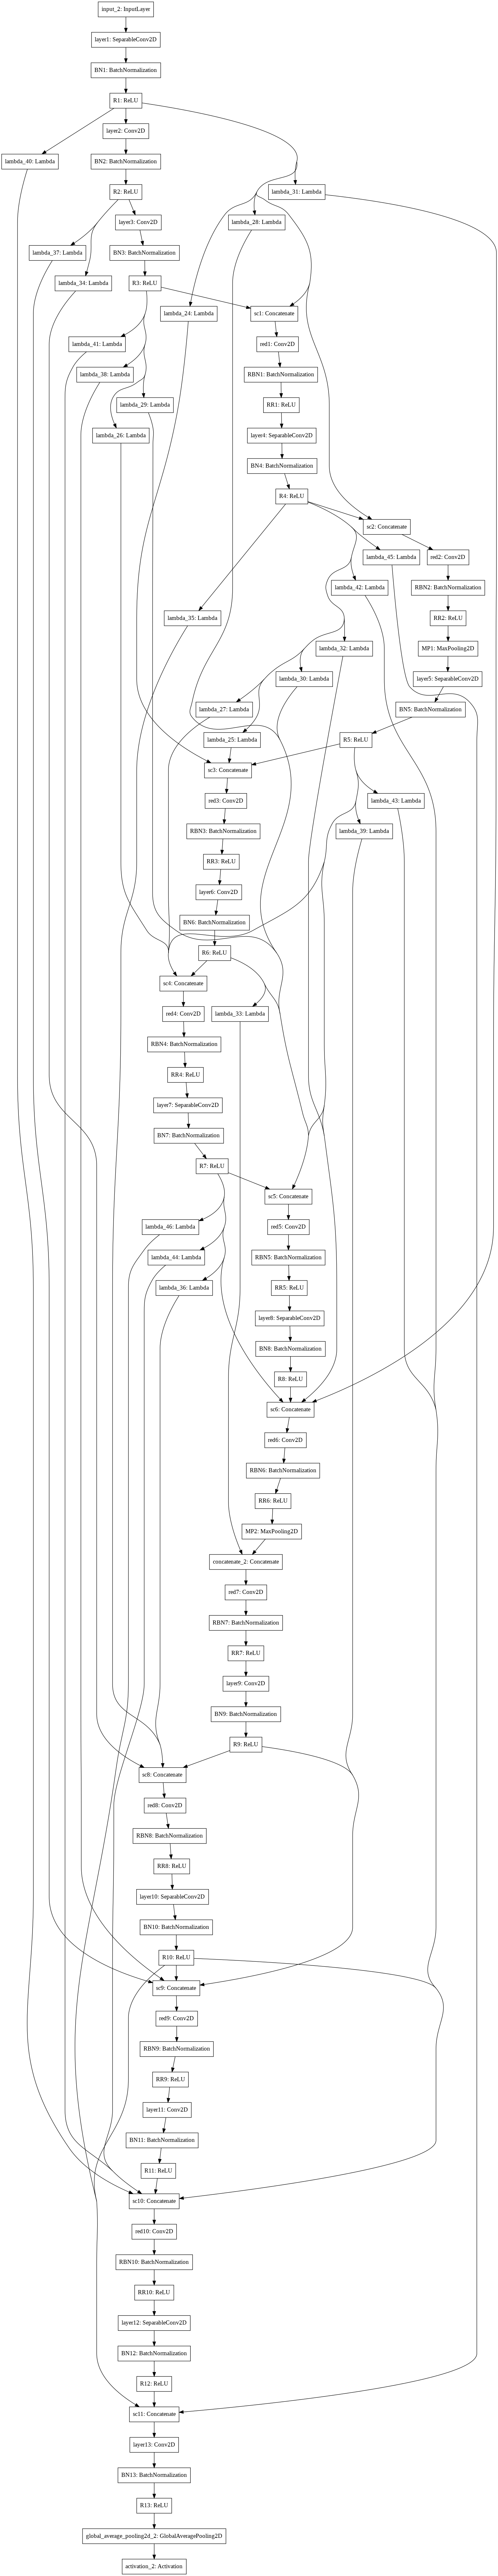

In [31]:
#plot the model as a png image and display it 

from keras.utils import plot_model
plot_model(model, to_file='model2.png')

from IPython.display import Image, display
display(Image('model2.png',width=1000,height=3000))

####print model summary

In [32]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
layer1 (SeparableConv2D)        (None, 32, 32, 8)    107         input_2[0][0]                    
__________________________________________________________________________________________________
BN1 (BatchNormalization)        (None, 32, 32, 8)    32          layer1[0][0]                     
__________________________________________________________________________________________________
R1 (ReLU)                       (None, 32, 32, 8)    0           BN1[0][0]                        
__________________________________________________________________________________________________
layer2 (Co

In [0]:


chkpoint_model=ModelCheckpoint("/gdrive/My Drive/EVA/session7/model_lite_enas_custom7_cifar10_best.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

### define learning rate scheduler

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  if (epoch%2==0 and epoch):
    new_lr = max(0.90*lr,0.00001) 
  else:
    new_lr=lr
  
  return round(new_lr, 10)

####compile model 

In [0]:
#start with a higher lr of 0.003 
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

### Image Normalization and Augmentation :
In order to help the network generalize better , we will normalize the input image with mu-sigma normalization and also augment the training image samples by using image augmentation techniques. We will add some transforms in random combinations like a zoom factor, shift of image and flipping the image horizontally. To do this we will use an ImageDataGenerator

####Define Imagedatagenerator with various combinations of horizontal flip set to True ,zoom range , shift image along width , shift image along height . All these will be applied in random combinations
We will then train model for a total of 100 epochs

In [36]:
from keras.preprocessing.image import ImageDataGenerator



train_datagen = ImageDataGenerator( 
                             horizontal_flip=True,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 3, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))


Epoch 1/3

Epoch 00001: LearningRateScheduler setting learning rate to 0.0099999998.
391/391 [==============================] - 38s 97ms/step - loss: 1.4104 - acc: 0.5026 - val_loss: 1.7282 - val_acc: 0.4685

Epoch 00001: val_acc improved from -inf to 0.46850, saving model to /gdrive/My Drive/EVA/session7/model_lite_enas_custom7_cifar10_best.h5
Epoch 2/3

Epoch 00002: LearningRateScheduler setting learning rate to 0.0099999998.
391/391 [==============================] - 29s 75ms/step - loss: 0.9262 - acc: 0.6767 - val_loss: 1.3608 - val_acc: 0.5591

Epoch 00002: val_acc improved from 0.46850 to 0.55910, saving model to /gdrive/My Drive/EVA/session7/model_lite_enas_custom7_cifar10_best.h5
Epoch 3/3

Epoch 00003: LearningRateScheduler setting learning rate to 0.0089999998.
391/391 [==============================] - 29s 75ms/step - loss: 0.7580 - acc: 0.7376 - val_loss: 1.1499 - val_acc: 0.6176

Epoch 00003: val_acc improved from 0.55910 to 0.61760, saving model to /gdrive/My Drive/EVA/se

In [37]:
train_datagen = ImageDataGenerator(zoom_range=[0.8,0.8], 
                             horizontal_flip=True, width_shift_range=0.5, height_shift_range=0.5,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 20, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.0089999996.
391/391 [==============================] - 32s 81ms/step - loss: 1.3474 - acc: 0.5261 - val_loss: 1.4492 - val_acc: 0.5546

Epoch 00001: val_acc did not improve from 0.61760
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0089999996.
391/391 [==============================] - 31s 79ms/step - loss: 1.2060 - acc: 0.5762 - val_loss: 1.5953 - val_acc: 0.5321

Epoch 00002: val_acc did not improve from 0.61760
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0080999997.
391/391 [==============================] - 31s 78ms/step - loss: 1.1336 - acc: 0.6030 - val_loss: 1.4222 - val_acc: 0.5647

Epoch 00003: val_acc did not improve from 0.61760
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0080999993.
391/391 [==============================] - 31s 78ms/step - loss: 1.0943 - acc: 0.6160 - val_loss: 1.3862 - val_acc: 0.5490

Epoch 0000

In [38]:
train_datagen = ImageDataGenerator(
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 2, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))

Epoch 1/2

Epoch 00001: LearningRateScheduler setting learning rate to 0.0034867842.
391/391 [==============================] - 29s 75ms/step - loss: 0.4254 - acc: 0.8535 - val_loss: 0.4586 - val_acc: 0.8438

Epoch 00001: val_acc improved from 0.71190 to 0.84380, saving model to /gdrive/My Drive/EVA/session7/model_lite_enas_custom7_cifar10_best.h5
Epoch 2/2

Epoch 00002: LearningRateScheduler setting learning rate to 0.0034867842.
391/391 [==============================] - 29s 75ms/step - loss: 0.3454 - acc: 0.8816 - val_loss: 0.4678 - val_acc: 0.8404

Epoch 00002: val_acc did not improve from 0.84380
Model took 59.30 seconds to train



In [39]:




train_datagen = ImageDataGenerator(zoom_range=[0.8,1], 
                             horizontal_flip=True, width_shift_range=0.35, height_shift_range=0.35,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 20, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))


Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.0034867842.
391/391 [==============================] - 31s 79ms/step - loss: 0.5900 - acc: 0.7940 - val_loss: 0.6471 - val_acc: 0.7855

Epoch 00001: val_acc did not improve from 0.84380
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0034867842.
391/391 [==============================] - 30s 77ms/step - loss: 0.5654 - acc: 0.8031 - val_loss: 0.7626 - val_acc: 0.7554

Epoch 00002: val_acc did not improve from 0.84380
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0031381058.
391/391 [==============================] - 30s 77ms/step - loss: 0.5442 - acc: 0.8113 - val_loss: 0.7569 - val_acc: 0.7561

Epoch 00003: val_acc did not improve from 0.84380
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0031381059.
391/391 [==============================] - 30s 77ms/step - loss: 0.5442 - acc: 0.8109 - val_loss: 0.6509 - val_acc: 0.7892

Epoch 0000

In [40]:




train_datagen = ImageDataGenerator(
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 20, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))


Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.0013508516.
391/391 [==============================] - 29s 75ms/step - loss: 0.2699 - acc: 0.9074 - val_loss: 0.3629 - val_acc: 0.8782

Epoch 00001: val_acc improved from 0.84380 to 0.87820, saving model to /gdrive/My Drive/EVA/session7/model_lite_enas_custom7_cifar10_best.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0013508516.
391/391 [==============================] - 29s 75ms/step - loss: 0.2262 - acc: 0.9240 - val_loss: 0.3653 - val_acc: 0.8760

Epoch 00002: val_acc did not improve from 0.87820
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0012157665.
391/391 [==============================] - 29s 75ms/step - loss: 0.2069 - acc: 0.9317 - val_loss: 0.3705 - val_acc: 0.8761

Epoch 00003: val_acc did not improve from 0.87820
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0012157665.
391/391 [==============================] - 

In [41]:




train_datagen = ImageDataGenerator(zoom_range=[0.8,1.0], 
                             horizontal_flip=True, width_shift_range=0.3, height_shift_range=0.3,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 5, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))


Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.0005233476.
391/391 [==============================] - 31s 80ms/step - loss: 0.4960 - acc: 0.8401 - val_loss: 0.6027 - val_acc: 0.8249

Epoch 00001: val_acc did not improve from 0.87820
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.0005233476.
391/391 [==============================] - 30s 77ms/step - loss: 0.4314 - acc: 0.8541 - val_loss: 0.6028 - val_acc: 0.8221

Epoch 00002: val_acc did not improve from 0.87820
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0004710128.
391/391 [==============================] - 30s 77ms/step - loss: 0.4060 - acc: 0.8606 - val_loss: 0.6016 - val_acc: 0.8202

Epoch 00003: val_acc did not improve from 0.87820
Epoch 4/5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0004710128.
391/391 [==============================] - 30s 77ms/step - loss: 0.4091 - acc: 0.8573 - val_loss: 0.5589 - val_acc: 0.8293

Epoch 00004: v

In [42]:




train_datagen = ImageDataGenerator(zoom_range=[0.8,0.8], 
                             horizontal_flip=True, width_shift_range=0.4, height_shift_range=0.4,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 10, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))


Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.0004239115.
391/391 [==============================] - 31s 78ms/step - loss: 0.5947 - acc: 0.7953 - val_loss: 0.7639 - val_acc: 0.7704

Epoch 00001: val_acc did not improve from 0.87820
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0004239115.
391/391 [==============================] - 30s 77ms/step - loss: 0.5617 - acc: 0.8034 - val_loss: 0.7782 - val_acc: 0.7688

Epoch 00002: val_acc did not improve from 0.87820
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.0003815203.
391/391 [==============================] - 30s 76ms/step - loss: 0.5541 - acc: 0.8079 - val_loss: 0.7253 - val_acc: 0.7776

Epoch 00003: val_acc did not improve from 0.87820
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003815203.
391/391 [==============================] - 30s 77ms/step - loss: 0.5489 - acc: 0.8078 - val_loss: 0.7238 - val_acc: 0.7789

Epoch 0000

In [43]:




train_datagen = ImageDataGenerator(zoom_range=[0.8,1.0], 
                             horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 15, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))


Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to 0.0002781283.
391/391 [==============================] - 30s 77ms/step - loss: 0.3282 - acc: 0.8844 - val_loss: 0.4759 - val_acc: 0.8433

Epoch 00001: val_acc did not improve from 0.87820
Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to 0.0002781283.
391/391 [==============================] - 30s 77ms/step - loss: 0.2867 - acc: 0.8997 - val_loss: 0.4649 - val_acc: 0.8440

Epoch 00002: val_acc did not improve from 0.87820
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to 0.0002503155.
391/391 [==============================] - 30s 76ms/step - loss: 0.2798 - acc: 0.9021 - val_loss: 0.4537 - val_acc: 0.8484

Epoch 00003: val_acc did not improve from 0.87820
Epoch 4/15

Epoch 00004: LearningRateScheduler setting learning rate to 0.0002503155.
391/391 [==============================] - 30s 76ms/step - loss: 0.2761 - acc: 0.9034 - val_loss: 0.4548 - val_acc: 0.8488

Epoch 0000

In [44]:
train_datagen = ImageDataGenerator(
                             horizontal_flip=True,
    
                             
                            featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            )

val_datagen=ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
        
                            featurewise_std_normalization=True,  # divide inputs by std of the dataset
                              )

train_datagen.fit(train_features)

val_datagen.fit(test_features)

batch_size=128

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model


model_info = model.fit_generator(training_generator,steps_per_epoch=np.ceil(train_features.shape[0]/batch_size),
                                 epochs = 5, 
                                 validation_data=validation_generator,
                                 validation_steps=np.ceil(test_features.shape[0]/batch_size),
                                 shuffle=True, 
                                 callbacks=[reduceLR,chkpoint_model],
                                 verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001330279.
391/391 [==============================] - 29s 75ms/step - loss: 0.1755 - acc: 0.9423 - val_loss: 0.3465 - val_acc: 0.8847

Epoch 00001: val_acc improved from 0.87820 to 0.88470, saving model to /gdrive/My Drive/EVA/session7/model_lite_enas_custom7_cifar10_best.h5
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001330279.
391/391 [==============================] - 29s 75ms/step - loss: 0.1636 - acc: 0.9465 - val_loss: 0.3444 - val_acc: 0.8854

Epoch 00002: val_acc improved from 0.88470 to 0.88540, saving model to /gdrive/My Drive/EVA/session7/model_lite_enas_custom7_cifar10_best.h5
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001197251.
391/391 [==============================] - 29s 75ms/step - loss: 0.1631 - acc: 0.9472 - val_loss: 0.3427 - val_acc: 0.8861

Epoch 00003: val_acc improved from 0.88540 to 0.88610, saving model to /gdrive/My Drive/EVA

### We built a model following the ENAS' discovered architecture 

### We added the following to help the network generalize better and avoid overfitting: 
###BatchNormalization , Image Normalization and Image Augmentation 

### We added a simple learning rate scheduler (ideally we should use a scheduler that changes LR on plateau) to help the network converge faster and avoid getting stuck at one learning rate

### For the last layer before Softmax predcition, we added GlobalAveragePooling to follow the design of the original paper .

### The first model with 4,300,221 parameters trained for 100 epochs and reached a max validation accuracy of 92.48

### The lighter model with 284,301 parameters trained for 100 epochs and reached a max validation accuracy of 88.61 

More training epochs and better augmentation techniques as mentioned in the paper(***standardizing the data, using horizontal flips with 50% probability, zero-padding and random crops, and finally Cutout with 16x16 pixels***) would have yielded better results 